In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import torch
import torchvision.transforms as transforms
import numpy as np
import yaml
import sys
import time
from scipy import interpolate
import os
import cv2
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
sys.path.append("../")
#sys.path.append("/mnt/lustre/share/zhanxiaohang/videoseg/lib/pydensecrf")
import pdb
import flowlib
import models
import utils
import importlib
importlib.reload(utils)
#exp = '../experiments/vip/resnet50_demo'
exp = '../experiments/vip+mpii/resnet50_skiplayer_demo'
#exp = '../experiments/youtube/resnet50_skiplayer_demo'

#load_path = "{}/checkpoints/ckpt_iter_65000.pth.tar".format(exp)
#load_path = "{}/checkpoints/ckpt_iter_35000.pth.tar".format(exp)
load_path = "{}/checkpoints/ckpt_iter_42000.pth.tar".format(exp)
config = "{}/config.yaml".format(exp)

In [2]:
class ArgObj(object):
    def __init__(self):
        pass

class suibian(torch.nn.Module):
    def __init__(self, m):
        super(suibian, self).__init__()
        self.module = m
    def forward(self, input1, input2):
        return self.module(input1, input2)

def image_resize(img, short_size):
    w, h = img.width, img.height
    if w < h:
        neww = short_size
        newh = int(short_size / float(w) * h)
    else:
        neww = int(short_size / float(h) * w)
        newh = short_size
    img = img.resize((neww, newh), Image.BICUBIC)
    return img

def image_crop(img, crop_size):
    pad_h = max(crop_size[0] - img.height, 0)
    pad_w = max(crop_size[1] - img.width, 0)
    pad_h_half = int(pad_h / 2)
    pad_w_half = int(pad_w / 2)
    if pad_h > 0 or pad_w > 0:
        border = (pad_w_half, pad_h_half, pad_w - pad_w_half, pad_h - pad_h_half)
        img = ImageOps.expand(img, border=border, fill=(0,0,0))
    hoff = (img.height - crop_size[0]) // 2
    woff = (img.width - crop_size[1]) // 2
    return img.crop((woff, hoff, woff+crop_size[1], hoff+crop_size[0]))

def flow_crop(flow, crop_size):
    pad_h = max(crop_size[0] - img.height, 0)
    pad_w = max(crop_size[1] - img.width, 0)
    pad_h_half = int(pad_h / 2)
    pad_w_half = int(pad_w / 2)
    if pad_h > 0 or pad_w > 0:
        flow_expand = np.zeros((img.height + pad_h, img.width + pad_w, 2), dtype=np.float32)
        flow_expand[pad_h_half:pad_h_half+img.height, pad_w_half:pad_w_half+img.width, :] = flow
        flow = flow_expand
    hoff = (img.height - crop_size[0]) // 2
    woff = (img.width - crop_size[1]) // 2
    return flow[hoff:hoff+crop_size[0], woff:woff+crop_size[1], :]

def image_flow_warp(img, flow, mask_th=1, copy=True, interp=True, interp_mode=0):
    
    warp_img = np.zeros(img.shape, dtype=img.dtype)
    flow_mask = (np.abs(flow[:,:,0]) > mask_th) | (np.abs(flow[:,:,1]) > mask_th)
    pts = np.where(flow_mask)
    vx_pts = flow[:,:,0][pts].astype(np.int)
    vy_pts = flow[:,:,1][pts].astype(np.int)
    v = flow[:,:,0][pts] ** 2 + flow[:,:,1][pts] ** 2
    sortidx = np.argsort(v)
    warp_pts = (pts[0] + vy_pts, pts[1] + vx_pts)
    warp_pts = (np.clip(warp_pts[0], 0, img.shape[0]-1), np.clip(warp_pts[1], 0, img.shape[1]-1))
    warp_pts = (warp_pts[0][sortidx], warp_pts[1][sortidx])
    pts = [pts[0][sortidx], pts[1][sortidx]]
    for c in range(3):
        if copy:
            warp_img[:,:,c][~flow_mask] = img[:,:,c][~flow_mask]
        warp_img[:,:,c][warp_pts] = img[:,:,c][pts]
    if interp:
        holes = ((warp_img.sum(axis=2) == 0) & flow_mask)
        if interp_mode == 0:
            hpts = np.where(holes)
            opts = (hpts[0]-flow[:,:,1][hpts].astype(np.int), hpts[1]-flow[:,:,0][hpts].astype(np.int))
            opts = (np.clip(opts[0], 0, img.shape[0]-1), np.clip(opts[1], 0, img.shape[1]-1))
            for c in range(3):
                warp_img[:,:,c][hpts] = img[:,:,c][opts]
        else:
            for c in range(3):
                warp_img[:,:,c][holes] = interpolate.griddata(np.where(~holes), warp_img[:,:,c][~holes], np.where(holes), method='cubic')
    return warp_img
    
    
class Demo(object):
    def __init__(self, configfn, load_path):
        args = ArgObj()
        with open(configfn) as f:
            config = yaml.load(f)
        for k, v in config['common'].items():
            setattr(args, k, v)
        setattr(args, 'load_path', load_path)
        
        self.model = suibian(models.__dict__[args.arch](
            args.kinematic['image_encoder'],
            args.kinematic.get('use_ppm', False),
            args.kinematic['flow_encoder'],
            args.kinematic.get('flow_decoder', 'MotionDecoder_v1'),
            img_enc_dim=args.kinematic['img_enc_dim'],
            flow_enc_dim=args.kinematic['flow_enc_dim'],
            output_dim=args.kinematic.get('output_dim', 2),
            pretrained=args.kinematic['pretrained'],
            sync_bn=args.sync_bn))
        self.model.cuda()
        if not os.path.isfile(args.load_path):
            raise Exception("Checkpoint not exist: {}".format(args.load_path))
        utils.load_state(args.load_path, self.model)
        self.model.eval()
        self.img_transform = transforms.Compose([
            transforms.Normalize(config.get('data_mean', [0., 0., 0.]), 
                                 config.get('data_div', [255., 255., 255.]))])
        self.args = args
        self.fuser = utils.Fuser(args.kinematic['nbins'], args.kinematic['fmax'])
        torch.cuda.synchronize()
        
    def def_input(self, image, repeat=1):
        self.rgb = image
        tensor = self.img_transform(torch.from_numpy(np.array(image).astype(np.float32).transpose((2,0,1))))
        self.image = tensor.unsqueeze(0).repeat(repeat,1,1,1)
    
    def run_seg(self, active_pts, still_pts, velocity=10., crf=False): # pts: list of (x,y)
        start = time.time()
        
        sparse = np.zeros((4, 2, self.image.size(2), self.image.size(3)), dtype=np.float32)
        mask = np.zeros((4, 2, self.image.size(2), self.image.size(3)), dtype=np.float32)
        for pt in active_pts:
            sparse[0,:,int(pt[1]),int(pt[0])] = np.array([velocity,0])
            sparse[1,:,int(pt[1]),int(pt[0])] = np.array([-velocity,0])
            sparse[2,:,int(pt[1]),int(pt[0])] = np.array([0, velocity])
            sparse[3,:,int(pt[1]),int(pt[0])] = np.array([0, -velocity])
            mask[:,:,int(pt[1]),int(pt[0])] = np.array([1, 1])
        for pt in still_pts:
            sparse[:,:,int(pt[1]),int(pt[0])] = np.array([0, 0])
            mask[:,:,int(pt[1]),int(pt[0])] = np.array([1, 1])
            
        image_var = torch.autograd.Variable(self.image.cuda(), volatile=True)
        sparse_var = torch.autograd.Variable(torch.from_numpy(sparse).cuda(), volatile=True)
        mask_var = torch.autograd.Variable(torch.from_numpy(mask).cuda(), volatile=True)
        
        prep_time = time.time() - start
        start = time.time()
        
        output, _ = self.model(image_var, torch.cat([sparse_var, mask_var], dim=1))
        output = torch.nn.functional.upsample(output, size=(image_var.size(2), image_var.size(3)), mode="bilinear")
        fw_time = time.time() - start
        start = time.time()
        
        flow, times = self.fuser.fusion_flow_tensor(output)
        post_time = time.time() - start
        #flow = flow.data.cpu().numpy()
            
        return flow, [prep_time, fw_time, post_time] + times
        
    def run(self, arrows, crf=False):
        sparse = np.zeros((1, 2, self.image.size(2), self.image.size(3)), dtype=np.float32)
        mask = np.zeros((1, 2, self.image.size(2), self.image.size(3)), dtype=np.float32)
        for arr in arrows:
            sparse[0, :, int(arr[1]), int(arr[0])] = np.array(arr[2:4])
            mask[0, :, int(arr[1]), int(arr[0])] = np.array([1, 1])
        image_var = torch.autograd.Variable(self.image.cuda(), volatile=True)
        sparse_var = torch.autograd.Variable(torch.from_numpy(sparse).cuda(), volatile=True)
        mask_var = torch.autograd.Variable(torch.from_numpy(mask).cuda(), volatile=True)

        output, _ = self.model(image_var, torch.cat([sparse_var, mask_var], dim=1))
        output = torch.nn.functional.upsample(output, size=(image_var.size(2), image_var.size(3)), mode="bilinear")
        
        if crf:
            flow = utils.fusion_flow_tensor(output, self.args.kinematic['fmax'], crf=True, 
                                            image=np.array(self.rgb).transpose((2,0,1))[np.newaxis,...])
        else:
            flow = utils.fusion_flow_tensor(output, self.args.kinematic['fmax'], crf=False)
        #flow = flow.data.cpu().numpy()
        
        return flow
    
class DrawSeg(object):
    def __init__(self):
        self.demo = Demo(config, load_path)
    
    def init_image(self, img, velocity=10., th=0.5, zoom_factor=-1, realtime=False, large=False, silent=False):
        
        self.crf = False
        self.velocity = velocity
        self.th = th
        self.realtime = realtime
        self.large = large
        self.silent = silent
        self.zoom_factor = zoom_factor
        if large:
            rows, cols = 1,1
        else:
            rows, cols = 2,4
        
        if 'short_size' in self.demo.args.kinematic.keys():
            img = image_resize(img, self.demo.args.kinematic['short_size'])
        img = image_crop(img, self.demo.args.kinematic['crop_size'])
        self.oriimg = img
        self.img = img
        self.fig = plt.figure(figsize=(6, 6))
        self.ax = self.fig.add_subplot(rows, cols, 1)
        if not large:
            self.axs = self.fig.add_subplot(rows, cols, 2)
            self.axf = [self.fig.add_subplot(rows, cols, j) for j in range(5,9)]
            self.axm = self.fig.add_subplot(rows, cols, 3)

        if not self.silent:
            self.status = self.ax.text(0, -20, "", va="bottom", ha="left", color='r')
            if not large:
                self.mode_status = self.axs.text(0, 0, "", va="bottom", ha="left", color='r')
            self.mode_status.set_text("mode: add")
            
        self.ax.imshow(img)
        
        if not large:
            self.axs.imshow(img)
            for j in range(4):
                self.axf[j].imshow(np.ones((img.height, img.width, 3), dtype=np.uint8) * 255)
            self.axm.imshow(np.zeros((img.height, img.width, 3), dtype=np.uint8))
        
        self.demo.def_input(img, repeat=4)
        self.ax.figure.show()
        self.active_pts = []
        self.still_pts = []
        self.obj_active_pts = []
        self.obj_still_pts = []
        self.add_mode = 0
        self.laid_mask = False
        
        self.connect()

    def refresh(self):
        self.ax.cla()
        img = self.oriimg
        self.ax.imshow(img)
        if not self.large:
            self.axs.imshow(img)
            for j in range(4):
                self.axf[j].imshow(np.ones((img.height, img.width, 3), dtype=np.uint8) * 255)
            self.axm.imshow(np.zeros((img.height, img.width, 3), dtype=np.uint8))
        
        self.demo.def_input(img, repeat=4)
        self.ax.figure.show()
        self.active_pts = []
        self.still_pts = []
        self.obj_active_pts = []
        self.obj_still_pts = []
        self.add_mode = 0
        self.laid_mask = False
        

        
    def get_zoom_ratio(self):
        pts = self.active_pts + self.still_pts
        allx = [p[0] for p in pts]
        ally = [p[1] for p in pts]
        minx, maxx = min(allx), max(allx)
        miny, maxy = min(ally), max(ally)
        sz = max(maxx - minx, maxy - miny) * self.zoom_factor
        sz = sz//2 * 2
        return float(self.oriimg.width) / sz
    
    def zoom(self):
        pts = self.active_pts + self.still_pts
        allx = [p[0] for p in pts]
        ally = [p[1] for p in pts]
        minx, maxx = min(allx), max(allx)
        miny, maxy = min(ally), max(ally)
        center = ((minx + maxx) //2, (miny + maxy) // 2)
        sz = min(max(maxx - minx, maxy - miny) * self.zoom_factor, self.oriimg.width)
        if sz == self.oriimg.width:
            bbox = [0, 0, sz, sz]
        else:
            sz = sz//2 * 2
            bbox = (center[0] - sz//2, center[1] - sz//2, center[0] + sz//2, center[1] + sz//2)
        self.img = self.oriimg.crop(bbox).resize(self.demo.args.kinematic['crop_size'], Image.BICUBIC)
        self.demo.def_input(self.img, repeat=4)
        return bbox, float(self.oriimg.width) / sz
    
    def unzoom(self, mask, bbox): # flow: NCHW
        bbox = [int(b) for b in bbox]
        h, w = mask.shape
        unzoom_mask = np.zeros(mask.shape, dtype=mask.dtype)
        sz = bbox[2] - bbox[0]
        mask_r = cv2.resize(mask, (sz, sz), interpolation=cv2.INTER_LINEAR)
        unzoom_mask[max(0,bbox[1]):min(h,bbox[3]), max(0,bbox[0]):min(w,bbox[2])] = \
            mask_r[max(0,-bbox[1]):min(sz,sz-bbox[3]+h), max(0,-bbox[0]):min(sz,sz-bbox[2]+w)]
        return unzoom_mask
        
    def print_info(self, string):
        if not self.silent:
            self.status.set_text(string)
            self.ax.figure.canvas.draw()
        
    def connect(self):
        self.cidpress = self.ax.figure.canvas.mpl_connect('button_press_event', self.on_press)
        self.cidkeypress = self.ax.figure.canvas.mpl_connect('key_press_event', self.on_key)
        
    def run_crf(self, mask, rgb): # mask: HW, rgb: HW3
        h, w = mask.shape
        #mask = 0.7 * (mask > 0.5).astype(np.float32)
        score = np.concatenate([1-mask[np.newaxis,:,:], mask[np.newaxis,:,:]], axis=0)
        return np.array(utils.densecrf(score, rgb, iter=1)).reshape(2, h, w)[1,:,:]
    
    def run_seg(self):
        self.print_info("Running")
        start = time.time()
        if len(self.active_pts + self.still_pts) > 1 and self.zoom_factor != -1:
            bbox, ratio = self.zoom()
            woff, hoff = bbox[0:2]
            zoom_active_pts = [((p[0] - woff) * ratio, (p[1] - hoff) * ratio) for p in self.active_pts]
            zoom_still_pts = [((p[0] - woff) * ratio, (p[1] - hoff) * ratio) for p in self.still_pts]
            self.flow, times = self.demo.run_seg(zoom_active_pts, zoom_still_pts, self.velocity, False) # crf False
        else:
            self.flow, times = self.demo.run_seg(self.active_pts, self.still_pts, self.velocity, False) # crf False
        self.print_info("prep: {:.3g} s, fw: {:.3g} s, post: {:.3g} s, sm: {:.3g} s, mul: {:.3g} s, cat: {:.3g} s, cpu: {:.3g} s".format(*times))
        if not self.large:
            for j in range(4):
                self.axf[j].imshow(flowlib.flow_to_image(self.flow[j,...].transpose((1,2,0))))
        self.maskori = np.mean(np.fabs(self.flow), axis=(0,1))
        if len(self.active_pts + self.still_pts) > 1 and self.zoom_factor != -1:
            self.maskori = self.unzoom(self.maskori, bbox)
        self.maskori /= self.maskori.max() # 0-1 float
        self.mask = self.maskori
        self.crf = False
        self.vlz_seg()
        
    def vlz_seg(self):
        self.thmask = (self.mask > self.th) # bool
        if not self.large:
            self.axm.imshow((255 * self.mask).astype(np.uint8))
        mask4c = np.zeros((self.mask.shape[0], self.mask.shape[1], 4), dtype=np.uint8)
        mask4c[:,:,1] = 255 * self.thmask.astype(np.uint8)
        mask4c[:,:,3] = int(255 * 0.25)
        if not self.large:
            blend = np.clip(mask4c[:,:,:3] * 0.25 + np.array(self.img) * 0.75, 0, 255).astype(np.uint8)
            self.axs.imshow(blend)
        
        if self.realtime:
            if self.laid_mask:
                self.axmask.remove()
            self.laid_mask = True
            self.axmask = self.ax.imshow(mask4c)
        
        self.ax.figure.canvas.draw()
       # self.print_info("Done")
            
    def on_key(self, event):
        if event.key == 'e':
            self.run_seg()
        elif event.key == 's':
            if self.add_mode == 0:
                self.add_mode = 1
                if not self.silent:
                    self.mode_status.set_text("mode: sub")
            else:
                self.add_mode = 0
                if not self.silent:
                    self.mode_status.set_text("mode: add")
            self.ax.figure.canvas.draw()
        elif event.key == 'c':
            if hasattr(self, 'maskori'):
                if self.crf:
                    self.mask = self.maskori
                    self.crf = False
                else:
                    self.mask = self.run_crf(self.maskori, np.array(self.img))
                    self.crf = True
                self.vlz_seg()
        elif event.key == 'f':
            self.refresh()
            
    def on_press(self, event):
        pts = (event.xdata, event.ydata)
        if pts[0] < 0 or pts[0] >= self.oriimg.width or pts[1] < 0 or pts[1] >= self.oriimg.height:
            return
        if event.button == 1:
            if self.add_mode == 1:
                pts = (event.xdata, event.ydata)
                self.still_pts.append(pts)
                self.obj_still_pts.append(self.ax.plot(pts[0], pts[1], '+', color='r', mew=2, ms=6))
                if not self.silent:
                    self.status.set_text("still point #{} added".format(len(self.still_pts)-1))
            else:
                pts = (event.xdata, event.ydata)
                self.active_pts.append(pts)
                self.obj_active_pts.append(self.ax.plot(pts[0], pts[1], '+', color='g', mew=2, ms=6))
                if not self.silent:
                    self.status.set_text("active point #{} added".format(len(self.active_pts)-1))
            if self.realtime:
                self.run_seg()
        if event.button == 3:
            x, y = event.xdata, event.ydata
            if len(self.active_pts) > 0 or len(self.still_pts) > 0:
                dist = [abs(x - pt[0]) + abs(y - pt[1]) for pt in self.active_pts + self.still_pts]
                delidx = np.argmin(dist)
                if delidx < len(self.active_pts):
                    self.obj_active_pts[delidx].pop().remove()
                    del self.obj_active_pts[delidx]
                    del self.active_pts[delidx]
                    if not self.silent:
                        self.status.set_text("active point #{} removed".format(delidx))
                else:
                    delidx -= len(self.active_pts)
                    self.obj_still_pts[delidx].pop().remove()
                    del self.obj_still_pts[delidx]
                    del self.still_pts[delidx]
                    if not self.silent:
                        self.status.set_text("still point #{} removed".format(delidx))
                if self.realtime:
                    self.run_seg()

    def disconnect(self):
        self.ax.figure.canvas.mpl_disconnect(self.cidpress)
        self.ax.figure.canvas.mpl_disconnect(self.cidkeypress)


objseg = DrawSeg()

=> loading checkpoint '../experiments/vip+mpii/resnet50_skiplayer_demo/checkpoints/ckpt_iter_42000.pth.tar'
caution: missing keys from checkpoint ../experiments/vip+mpii/resnet50_skiplayer_demo/checkpoints/ckpt_iter_42000.pth.tar: module.image_encoder.layer2.1.bn1.num_batches_tracked
caution: missing keys from checkpoint ../experiments/vip+mpii/resnet50_skiplayer_demo/checkpoints/ckpt_iter_42000.pth.tar: module.flow_encoder.features.5.num_batches_tracked
caution: missing keys from checkpoint ../experiments/vip+mpii/resnet50_skiplayer_demo/checkpoints/ckpt_iter_42000.pth.tar: module.flow_decoder.decoder2.8.num_batches_tracked
caution: missing keys from checkpoint ../experiments/vip+mpii/resnet50_skiplayer_demo/checkpoints/ckpt_iter_42000.pth.tar: module.image_encoder.layer2.0.bn1.num_batches_tracked
caution: missing keys from checkpoint ../experiments/vip+mpii/resnet50_skiplayer_demo/checkpoints/ckpt_iter_42000.pth.tar: module.flow_decoder.decoder8.2.num_batches_tracked
caution: missing

<IPython.core.display.Javascript object>


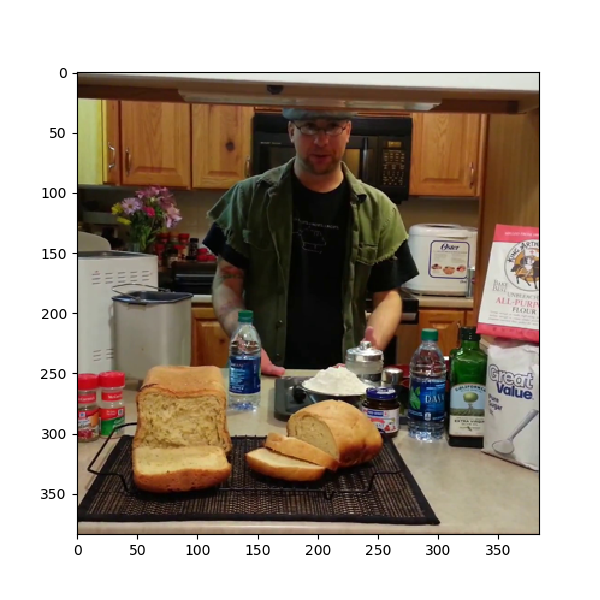

In [25]:
# tips:
# 1. left click to add positive points (green).
# 2. right right to remove a nearset points.
# 3. press "s" to switch to negative mode where left click adds negative points (red). Press "s" again to switch back.
# 4. Points should not be too close to object boundaries.
# 5. For extremely tiny objects, click more than 2 points.
# 6. Press "f" to finish the current object.
# 7. Try to annotate any thing.

test_image_idx = 505 # [0,1000)
target = 'MPII'

with open('/home/xhzhan/Share/transfer/{}/list.txt'.format(target), 'r') as f:
    lines = f.readlines()
fns = ['/home/xhzhan/Share/transfer/{}/'.format(target) + l.strip() for l in lines]
fn = fns[test_image_idx]

img = Image.open(fn).convert("RGB")
objseg.init_image(img, velocity=50., th=0.5, zoom_factor=4, realtime=True, large=True, silent=True)
